In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class SecondPriceAuction:
    # Starts a new round
    def __init__(self, bid_levels = 11):
        self.bid_levels = bid_levels
        self.bids = np.linspace(0, 1, bid_levels) # [0.0, 0.1, 0.2, ..., 1.0]
        self.reset()

    # Resets the auction for a new round
    def reset(self):
        self.agent_value = np.random.uniform(0, 1)
        self.opponent_value = np.random.uniform(0, 1)
        return self.agent_value
    
    def step(self, agent_bid):
        opponent_bid = self.opponent_value
        if agent_bid > opponent_bid:
            price_paid = opponent_bid
            reward = self.agent_value - price_paid
        else:
            reward = 0
        done = True  # In a single round auction, the episode ends after one step
        return self.agent_value, reward, done, {}

In [3]:
class QLearningAgent:
    def __init__(self, value_bins = 11, bid_levels = 11, alpha = 0.1, gamma = 0.0, epsilon = 0.0):
        self.value_bins = value_bins
        self.bid_levels = bid_levels
        self.alpha = alpha # Learning Rate
        self.gamma = gamma # Discount Factor
        self.epsilon = epsilon # Exploration Rate
        
        # Q-Table: rows = value bins, columns = bid actions
        self.Q = np.zeros((value_bins, bid_levels))

    # Convert continuous value to discrete bin
    def discretize_value(self, value):
        bin_width = 1.0 / self.value_bins
        return min(int(value / bin_width), self.value_bins - 1)
    
    def choose_action(self, value):
        state_idx = self.discretize_value(value)
        # Choose random action with probability epsilon
        if np.random.rand() < self.epsilon:
            # Return random bid level
            return np.random.choice(self.bid_levels)
        else:
            # Choose best action based on Q-Table
            return np.argmax(self.Q[state_idx])
    
    def learn(self, value, action, reward):
        state_idx = self.discretize_value(value)
        current_q = self.Q[state_idx, action]
        # Since it is a one step episode, no future reward
        self.Q[state_idx, action] = current_q + self.alpha * (reward - current_q)


In [4]:
env = SecondPriceAuction(bid_levels = 21)
agent = QLearningAgent(value_bins = 21, bid_levels = 21, alpha = 0.05, gamma = 0.0, epsilon = 0.1)
episodes = 100000
reward_history = []

for ep in range(episodes):
    value = env.reset() # Reset the environment, random value
    action = agent.choose_action(value)
    bid = action / (agent.bid_levels - 1)  # scale index to [0,1]
    _, reward, _, _ = env.step(bid)
    agent.learn(value, action, reward)
    reward_history.append(reward)

    if ep % 1000 == 0:
        avg_reward = np.mean(reward_history[-1000:])
        print(f"Episode {ep}, Average Reward: {avg_reward:.2f}")

# Percent of valuation bins where bid is within 5% of the true value
close_count = 0
for i in range(agent.value_bins):
    true_value = i / (agent.value_bins - 1)
    best_bid_idx = np.argmax(agent.Q[i])
    best_bid = best_bid_idx / (agent.bid_levels - 1)
    if abs(best_bid - true_value) <= 0.05:
        close_count += 1

accuracy = (close_count / agent.value_bins)
print(f"Bid accuracy within 5% of true value: {accuracy * 100:.2f}%")

Episode 0, Average Reward: 0.00
Episode 1000, Average Reward: 0.12
Episode 2000, Average Reward: 0.13
Episode 3000, Average Reward: 0.13
Episode 4000, Average Reward: 0.14
Episode 5000, Average Reward: 0.14
Episode 6000, Average Reward: 0.14
Episode 7000, Average Reward: 0.14
Episode 8000, Average Reward: 0.13
Episode 9000, Average Reward: 0.15
Episode 10000, Average Reward: 0.14
Episode 11000, Average Reward: 0.14
Episode 12000, Average Reward: 0.13
Episode 13000, Average Reward: 0.14
Episode 14000, Average Reward: 0.15
Episode 15000, Average Reward: 0.14
Episode 16000, Average Reward: 0.15
Episode 17000, Average Reward: 0.14
Episode 18000, Average Reward: 0.14
Episode 19000, Average Reward: 0.14
Episode 20000, Average Reward: 0.13
Episode 21000, Average Reward: 0.15
Episode 22000, Average Reward: 0.14
Episode 23000, Average Reward: 0.16
Episode 24000, Average Reward: 0.14
Episode 25000, Average Reward: 0.14
Episode 26000, Average Reward: 0.15
Episode 27000, Average Reward: 0.15
Episo

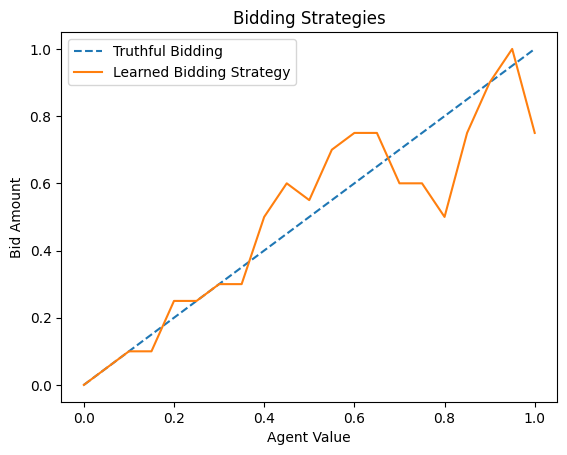

In [5]:
# Plot optimal bids
optimal_bids = [np.argmax(agent.Q[i]) / (agent.bid_levels - 1) for i in range(agent.value_bins)]
x_vals = np.linspace(0, 1, agent.value_bins)

plt.plot(x_vals, x_vals, label = "Truthful Bidding", linestyle = '--')
plt.plot(x_vals, optimal_bids, label = "Learned Bidding Strategy")
plt.xlabel("Agent Value")
plt.ylabel("Bid Amount")
plt.title("Bidding Strategies")
plt.legend()
plt.show()